> # **Project - 1 | Feature Ablation**

> **Objective**

- Measure how each preprocessing step (cleaning, stopword removal, lemmatization, etc.) affects model accuracy on a text classification task.
______________________________________________________________________________

- Keep model fixed
- Change preprocessing pipeline
- Measure accuracy / F1
- Compare results

> Dataset
- IMDB Sentiment Dataset (binary classification)

In [2]:
# importing the libraries
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parse'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 120.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Loading the dataset
from datasets import load_dataset

dataset = load_dataset('imdb')

# Convert to Python Lists (for sklearn pipeline)
x_train = dataset['train']['text']
y_train = dataset['train']['label']

x_test = dataset['test']['text']
y_test = dataset['test']['label']

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

# Optional: smaller subset for faster experiments
x_train_1 = x_train[:25000]
y_train_1 = y_train[:25000]

x_test_1 = x_test[:25000]
y_test_1 = y_test[:25000]

print(len(x_train_1), len(y_train_1))
print(len(x_test_1), len(y_test_1))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

25000 25000
25000 25000
25000 25000
25000 25000


In [4]:
from huggingface_hub import TokenClassificationInput
# Preprocessing Function
def preprocessing(texts, lowercase=True, remove_punct=False,
               remove_stop=False, lemmatize=False):

  preprocess_texts = []

  docs = nlp.pipe(texts, batch_size=500)

  for doc in docs:
    tokens = []

    for token in doc:
      if remove_punct and token.is_punct:
        continue

      if remove_stop and token.is_stop:
        continue

      if lemmatize:
        word = token.lemma_
      else:
        word = token.text

      if lowercase:
        word = word.lower()

      tokens.append(word)

    preprocess_texts.append(' '.join(tokens))

  return preprocess_texts

# x_train_1 = x_train[:1000]
# res = preprocessing(x_train_1, lowercase=True, remove_punct=True, remove_stop=True, lemmatize=True)
# print(res[:100])

In [5]:
# Define Experiment Runner
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def run_experiment(x_train, y_train, x_test, y_test, preprocess_args, use_tfidf=False, ngram=(1,1)):

  x_train_p = preprocessing(x_train, **preprocess_args)        # ** is dictionary unpacking in Python - expands a dictionary into named function arguments.
  x_test_p = preprocessing(x_test, **preprocess_args)

  if use_tfidf:
    vectorizer = TfidfVectorizer(ngram_range=ngram)
  else:
    vectorizer = CountVectorizer(ngram_range=ngram)

  x_train_vec = vectorizer.fit_transform(x_train_p)
  x_test_vec = vectorizer.transform(x_test_p)

  model = LogisticRegression(max_iter=1000)
  model.fit(x_train_vec, y_train)

  preds = model.predict(x_test_vec)

  accuracy = accuracy_score(y_test, preds)
  f1 = f1_score(y_test, preds)

  return accuracy, f1

In [6]:
# results
results = {}

results['Raw'] = run_experiment(
    x_train_1, y_train_1,
    x_test_1, y_test_1,
    preprocess_args={'lowercase': False,
                     'remove_punct': False,
                     'remove_stop': False,
                     'lemmatize': False}
)

results['No_Stopwords'] = run_experiment(x_train_1, y_train_1, x_test_1, y_test_1, preprocess_args={'lowercase': True,
                                                                                                'remove_punct': True,
                                                                                                'remove_stop': True})

results['Stopword_Lemma'] = run_experiment(x_train_1, y_train_1, x_test_1, y_test_1, preprocess_args={'lowercase': True,
                                                                                                'remove_punct': True,
                                                                                                'remove_stop': True,
                                                                                                'lemmatize': True}
                                         )

results['Stop_Lemma_Tfidf'] = run_experiment(x_train_1, y_train_1, x_test_1, y_test_1, preprocess_args={'lowercase': True,
                                                                                            'remove_punct': True,
                                                                                            'remove_stop': True,
                                                                                            'lemmatize': True
                                                                                            },
                                     use_tfidf = True
                                     )

print(results)

{'Raw': (0.86604, 0.8649433399201516), 'No_Stopwords': (0.85752, 0.8562666451456702), 'Stopword_Lemma': (0.84848, 0.8466769205860925), 'Stop_Lemma_Tfidf': (0.87568, 0.8756899448044156)}


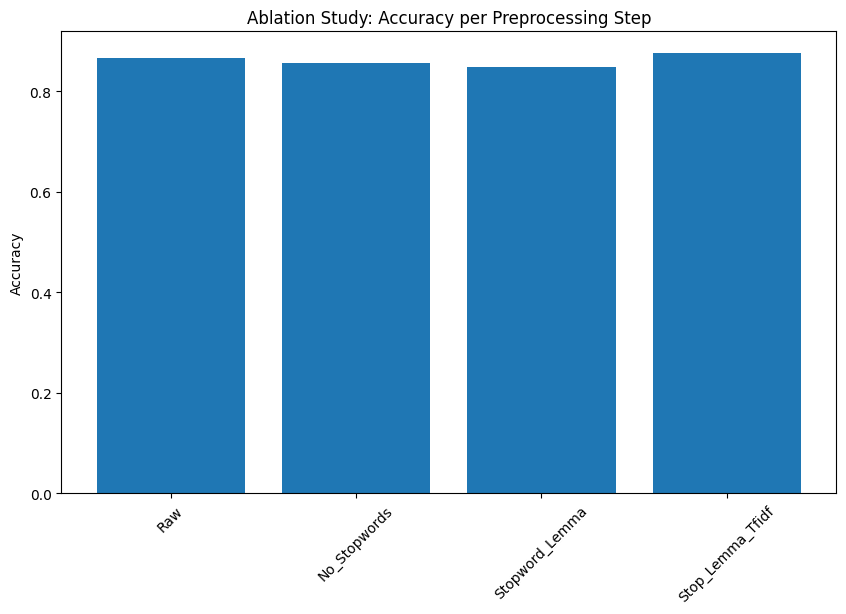

In [8]:
# Visualize Accuracy Change
# separate the accuracy and f1_score
accuracies = {k: v[0] for k, v in results.items()}
f1_scores = {k: v[1] for k, v in results.items()}

names = list(accuracies.keys())
scores = list(accuracies.values())

plt.figure(figsize=(10,6))
plt.bar(names, scores)
plt.xticks(rotation=45)
plt.title("Ablation Study: Accuracy per Preprocessing Step")
plt.ylabel('Accuracy')
plt.show()

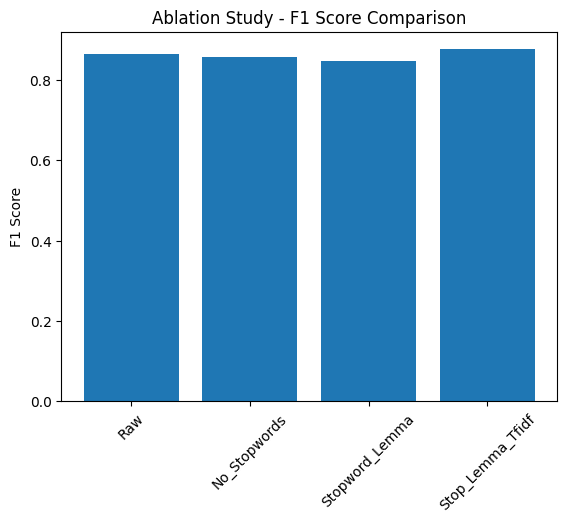

In [9]:
# f1_score plot
names = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure()
plt.bar(names, scores)
plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.title("Ablation Study - F1 Score Comparison")
plt.show()

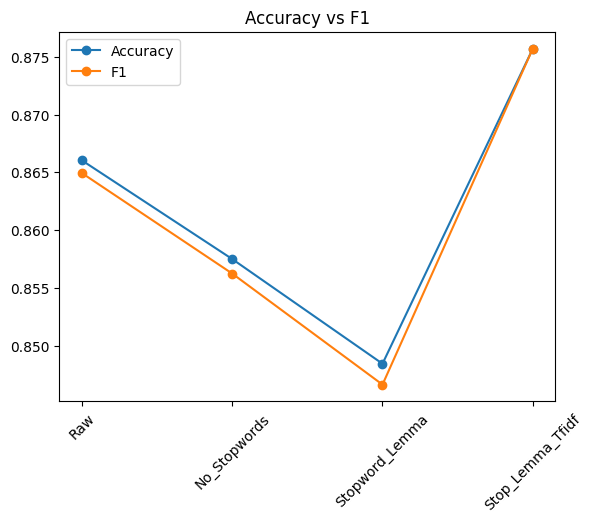

In [10]:
# Compare Both in One Plot
plt.figure()
plt.plot(accuracies.keys(), accuracies.values(), marker='o')
plt.plot(f1_scores.keys(), f1_scores.values(), marker='o')
plt.legend(["Accuracy", "F1"])
plt.xticks(rotation=45)
plt.title("Accuracy vs F1")
plt.show()